In [38]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

import numpy as np

import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

from PIL import Image

In [39]:
device = torch.device('cuda:1')

In [40]:
class Unfold(object):
    def __init__(self, crop_size, stride):
        self.crop_size = crop_size
        self.stride = stride
        
    def __call__(self, image):
        n_channels = image.shape[0]
        image = image \
            .unfold(1, self.crop_size, self.stride) \
            .unfold(2, self.crop_size, self.stride)
        image = image.permute(1,2,0,3,4)
        if n_channels == 1:
            image = image.reshape(-1, self.crop_size, self.crop_size)
        else:
            image = image.reshape(-1, n_channels, self.crop_size, self.crop_size)
        
        return image

color2idx = {
    (0, 0, 0): 0,
    (255, 255, 0): 1,
    (150, 80, 0): 2,
    (100, 100, 100): 3,
    (0, 0, 150): 4,
    (0, 255, 0): 5,
    (0, 125, 0): 6,
    (150, 150, 250): 7,
    (255, 255, 255): 8
}

idx2color = { v: k for k, v in color2idx.items() }

def rgb_to_cat(rgb_arr):
    arr = np.zeros(rgb_arr.shape[:2])
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if tuple(rgb_arr[i,j]) in color2idx:
                arr[i,j] = color2idx[tuple(rgb_arr[i,j])]
            else:
                arr[i,j] = 0
        
    return arr

def cat_to_rgb(cat_arr):
    arr = np.zeros((*cat_arr.shape[:2], 3), dtype=np.int)
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if cat_arr[i,j] in idx2color:
                arr[i,j] = idx2color[cat_arr[i,j]]
            else:
                arr[i,j] = (255, 255, 255)
    
    return arr

In [41]:
model = smp.Unet('efficientnet-b0', classes=len(color2idx), activation='softmax').to(device)
model.load_state_dict(torch.load('model_bri_0112_copy_2_wei_3.pt'))

<All keys matched successfully>

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    Unfold(crop_size=128, stride=128),
])

In [43]:
test_image = np.array(Image.open('./data/test/SKKU_Photo5-sat.png').convert('RGB'))[:,:,:3]
test_gt = np.array(Image.open('./data/test/SKKU_Photo5-gt.png').convert('RGB'))[:,:,:3]
transformed_test_image = transform(test_image)

In [44]:
test_set = TensorDataset(transformed_test_image)
test_loader = DataLoader(test_set, batch_size=300)

model.eval()
with torch.no_grad():
    for test_x in test_loader:
        test_x = test_x[0].to(device)
        
        outputs = model(test_x)
        _, pred = outputs.max(1)
        result = pred

In [45]:
result = result.reshape(8,8,128,128)
result = result.permute(0,2,1,3).reshape(1024,1024)

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

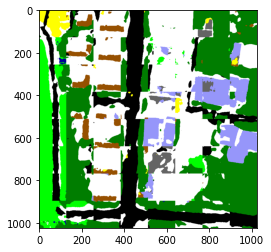

In [47]:
test_pred = cat_to_rgb(result.cpu().numpy())
plt.imshow(test_pred)

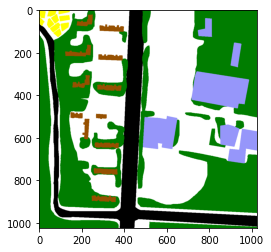

In [48]:
plt.imshow(test_gt)

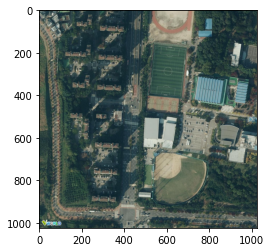

In [37]:
plt.imshow(test_image)